In [1]:
using DataFrames: DataFrame
using Plots: Plot, plot, heatmap
using GLM

include("../src/SimPlot.jl")
using .SimPlot

In [2]:
function plot_heatmap(df::DataFrame, symbol::Symbol)::Plot
    β = sort(unique(df.β))
    σ = sort(unique(df.σ))

    return heatmap(
        σ,
        β,
        reshape([SimPlot.get_value(df, s, b, :σ, :β, symbol) for b in β, s in σ], length(β), length(σ)),
        xlabel = "σ",
        ylabel = "β",
        xlims = (-0.025, 1.025),
        ylims = (-0.025, 1.025),
        xticks = 0:0.1:1,
        yticks = 0:0.1:1,
        title = symbol,
    )
end;

In [3]:
df_vec = SimPlot.csv_to_df([
    "20230915_194414", "20230915_222321", "20230915_232450",  # PDのみ
    "20230916_204517", "20230917_175747", "20230918_211924",  # All types of games (1.0 step)
    "20230920_100239",   # All types of games (0.5 step)
])
mean_df = SimPlot.make_mean_df(df_vec)
mean_df_PD = mean_df[mean_df.T .== 1.1 .&& mean_df.S .== -0.1, :]
mean_df_SD = mean_df[mean_df.T .== 1.1 .&& mean_df.S .== 0.1, :]
mean_df_SH = mean_df[mean_df.T .== 0.9 .&& mean_df.S .== -0.1, :]
mean_df_ND = mean_df[mean_df.T .== 0.9 .&& mean_df.S .== 0.1, :]
@show size(mean_df);

size(mean_df) = (3516, 19)


In [4]:
mean_df[1, 4:9]

DataFrameRow
 Row │ initial_graph_weight  interaction_freqency  relationship_volatility  bi ⋯
     │ Float64               Float64               Float64                  Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │                  0.2                   1.0                      0.1     ⋯
                                                               3 columns omitted

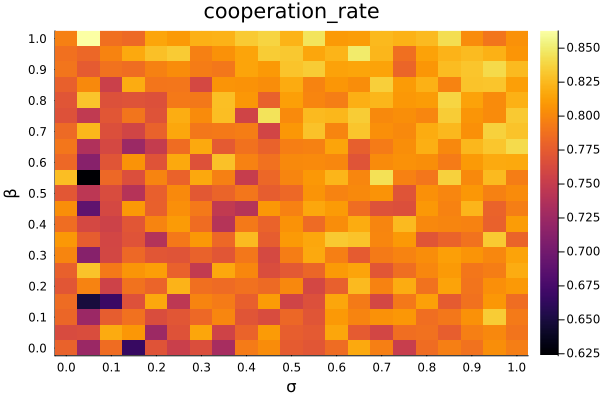

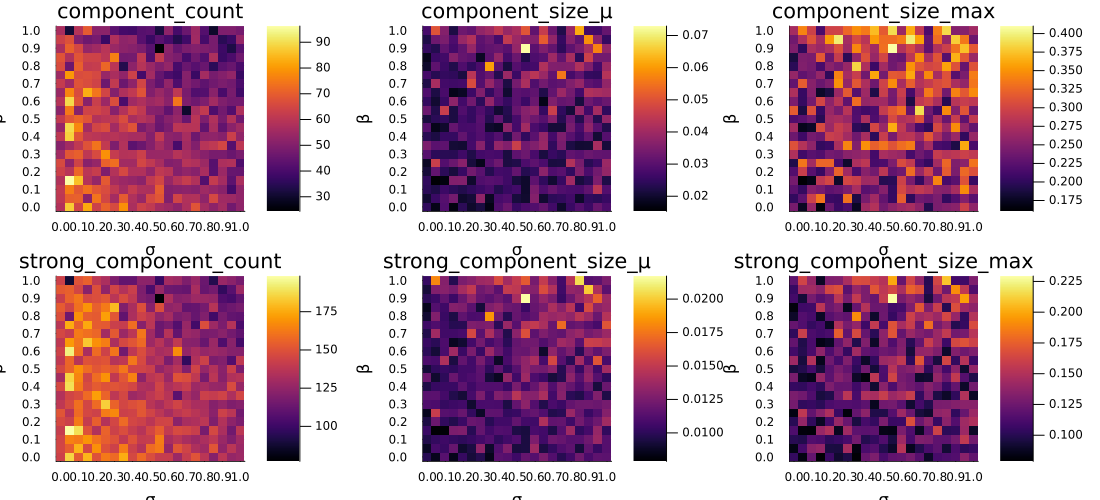

In [5]:
display(plot_heatmap(mean_df_PD, :cooperation_rate))

plot(
    plot_heatmap(mean_df_PD, :component_count),
    plot_heatmap(mean_df_PD, :component_size_μ),
    plot_heatmap(mean_df_PD, :component_size_max),
    plot_heatmap(mean_df_PD, :strong_component_count),
    plot_heatmap(mean_df_PD, :strong_component_size_μ),
    plot_heatmap(mean_df_PD, :strong_component_size_max),
    layout = (2, 3),
    size = (1100, 500),
)

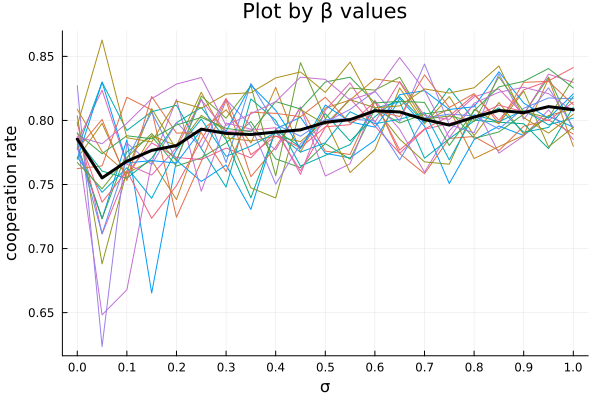

In [6]:
using StatsBase: mean
using DataFrames: combine, groupby
using Plots: plot!

agg_df = combine(groupby(mean_df_PD, [:β, :σ]), :cooperation_rate => mean => :mean_cooperation_rate)

p = plot(xticks = 0:0.1:1, xl = "σ", yl = "cooperation rate", title = "Plot by β values")

for subdf in groupby(agg_df, :β)
    plot!(subdf.σ, subdf.mean_cooperation_rate, label=false)
end

overall_mean_df = combine(groupby(agg_df, :σ), :mean_cooperation_rate => mean => :mean_cooperation_rate)
plot!(overall_mean_df.σ, overall_mean_df.mean_cooperation_rate, line = (:black, 3), label=false)

display(p)

In [7]:
lm(@formula(cooperation_rate ~ β + σ), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

cooperation_rate ~ 1 + β + σ

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.761112   0.00182876  416.19    <1e-99  0.757524   0.7647
β            0.0279658  0.00243712   11.47    <1e-28  0.0231839  0.0327478
σ            0.0379871  0.00243712   15.59    <1e-48  0.0332052  0.0427691
──────────────────────────────────────────────────────────────────────────

In [8]:
lm(@formula(cooperation_rate ~ component_size_μ + N), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

cooperation_rate ~ 1 + component_size_μ + N

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)        0.765648    0.00852899  89.77    <1e-99   0.748913     0.782383
component_size_μ   2.48506     0.0678598   36.62    <1e-99   2.35191      2.61821
N                 -3.91099e-5  7.15776e-6  -5.46    <1e-07  -5.31543e-5  -2.50655e-5
────────────────────────────────────────────────────────────────────────────────────

In [9]:
lm(@formula(component_count ~ β + σ), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

component_count ~ 1 + β + σ

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   69.5218    0.646068  107.61    <1e-99    68.2541    70.7894
β            -10.1638    0.860988  -11.80    <1e-29   -11.8531    -8.4744
σ            -18.5685    0.860988  -21.57    <1e-85   -20.2578   -16.8791
─────────────────────────────────────────────────────────────────────────

In [10]:
lm(@formula(strong_component_count ~ β + σ), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

strong_component_count ~ 1 + β + σ

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  164.365      1.0511   156.37    <1e-99   162.303    166.427
β            -15.7601     1.40075  -11.25    <1e-27   -18.5086   -13.0117
σ            -36.4408     1.40075  -26.02    <1e-99   -39.1892   -33.6923
─────────────────────────────────────────────────────────────────────────

In [11]:
lm(@formula(component_size_μ ~ β + σ), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

component_size_μ ~ 1 + β + σ

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  0.0222879   0.000584462  38.13    <1e-99  0.0211411   0.0234347
β            0.00757488  0.000778888   9.73    <1e-20  0.00604661  0.00910315
σ            0.00726145  0.000778888   9.32    <1e-19  0.00573318  0.00878972
─────────────────────────────────────────────────────────────────────────────

In [12]:
lm(@formula(strong_component_size_μ ~ β + σ), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

strong_component_size_μ ~ 1 + β + σ

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  0.00944854  0.000132615  71.25    <1e-99  0.00918834  0.00970875
β            0.00214118  0.000176731  12.12    <1e-31  0.00179441  0.00248795
σ            0.00232846  0.000176731  13.18    <1e-36  0.00198169  0.00267523
─────────────────────────────────────────────────────────────────────────────

In [13]:
lm(@formula(component_size_max ~ β + σ), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

component_size_max ~ 1 + β + σ

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.224945   0.00369591  60.86    <1e-99  0.217693   0.232197
β            0.043985   0.00492539   8.93    <1e-17  0.0343208  0.0536492
σ            0.0425875  0.00492539   8.65    <1e-16  0.0329233  0.0522517
─────────────────────────────────────────────────────────────────────────

In [14]:
lm(@formula(strong_component_size_max ~ β + σ), mean_df_PD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

strong_component_size_max ~ 1 + β + σ

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.100096   0.00186337  53.72    <1e-99  0.0964403  0.103753
β            0.0234184  0.00248323   9.43    <1e-19  0.018546   0.0282908
σ            0.0229811  0.00248323   9.25    <1e-18  0.0181087  0.0278535
─────────────────────────────────────────────────────────────────────────

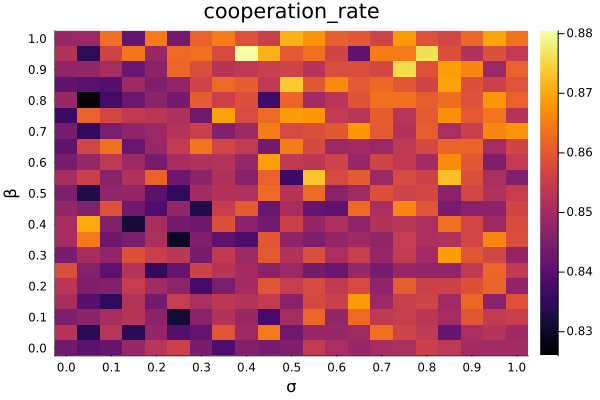

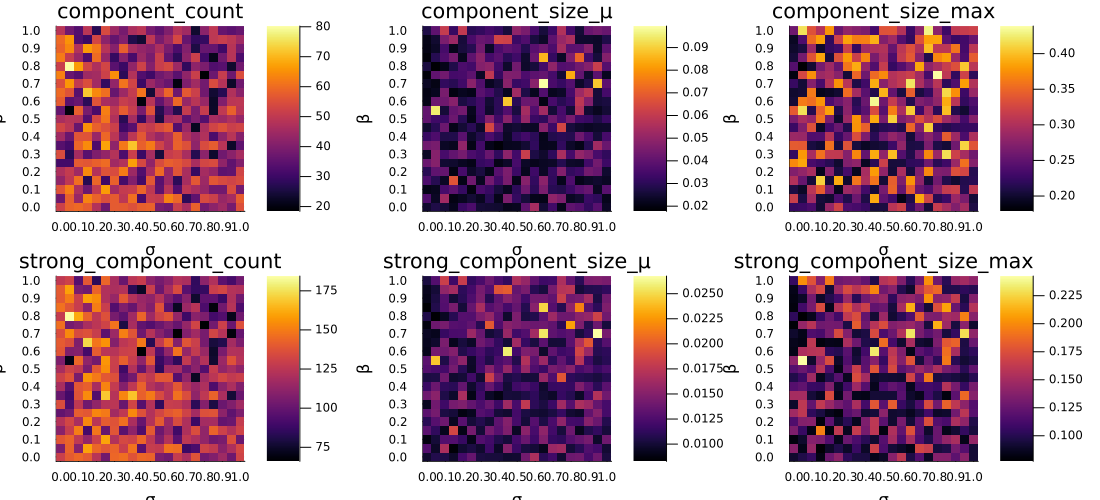

In [15]:
display(plot_heatmap(mean_df_SD, :cooperation_rate))

plot(
    plot_heatmap(mean_df_SD, :component_count),
    plot_heatmap(mean_df_SD, :component_size_μ),
    plot_heatmap(mean_df_SD, :component_size_max),
    plot_heatmap(mean_df_SD, :strong_component_count),
    plot_heatmap(mean_df_SD, :strong_component_size_μ),
    plot_heatmap(mean_df_SD, :strong_component_size_max),
    layout = (2, 3),
    size = (1100, 500),
)

In [16]:
lm(@formula(cooperation_rate ~ β + σ), mean_df_SD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

cooperation_rate ~ 1 + β + σ

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error        t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  0.842334    0.000732493  1149.95    <1e-99  0.840896    0.843772
β            0.00958502  0.000949268    10.10    <1e-21  0.00772167  0.0114484
σ            0.0111137   0.000949268    11.71    <1e-28  0.00925038  0.0129771
──────────────────────────────────────────────────────────────────────────────

In [17]:
lm(@formula(component_count ~ β + σ), mean_df_SD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

component_count ~ 1 + β + σ

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  53.6291      1.04457  51.34    <1e-99   51.5787    55.6795
β            -7.17791     1.35371  -5.30    <1e-06   -9.83514   -4.52068
σ            -9.37087     1.35371  -6.92    <1e-11  -12.0281    -6.71364
────────────────────────────────────────────────────────────────────────

In [18]:
lm(@formula(component_size_μ ~ β + σ), mean_df_SD)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

component_size_μ ~ 1 + β + σ

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  0.028116    0.00121926  23.06    <1e-89  0.0257227   0.0305093
β            0.00760154  0.00158009   4.81    <1e-05  0.00449993  0.0107032
σ            0.00464758  0.00158009   2.94    0.0034  0.00154598  0.00774919
────────────────────────────────────────────────────────────────────────────

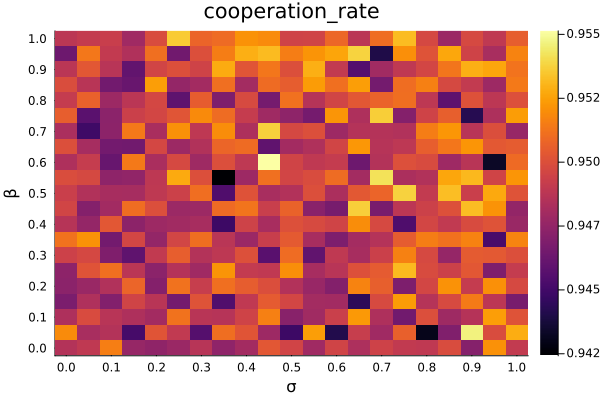

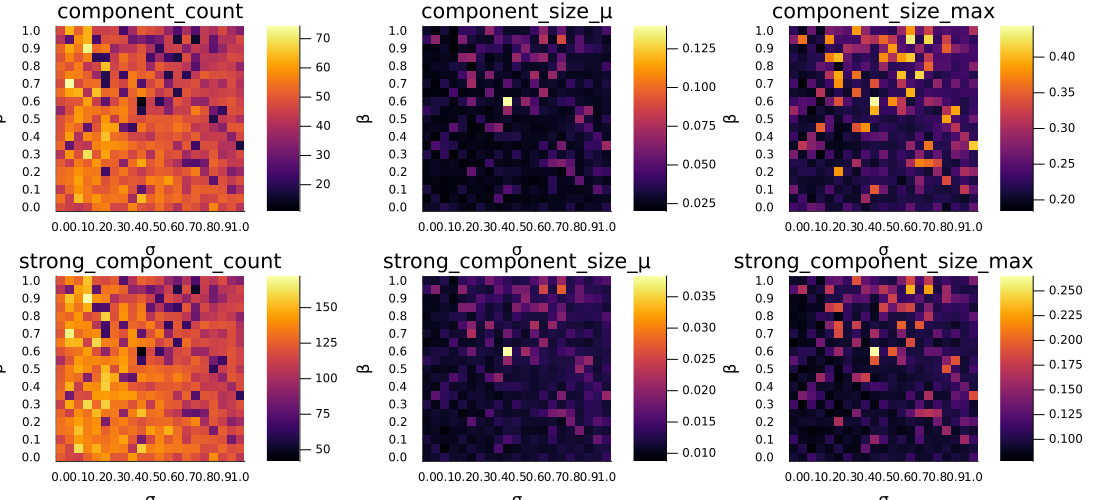

In [19]:
display(plot_heatmap(mean_df_SH, :cooperation_rate))

plot(
    plot_heatmap(mean_df_SH, :component_count),
    plot_heatmap(mean_df_SH, :component_size_μ),
    plot_heatmap(mean_df_SH, :component_size_max),
    plot_heatmap(mean_df_SH, :strong_component_count),
    plot_heatmap(mean_df_SH, :strong_component_size_μ),
    plot_heatmap(mean_df_SH, :strong_component_size_max),
    layout = (2, 3),
    size = (1100, 500),
)

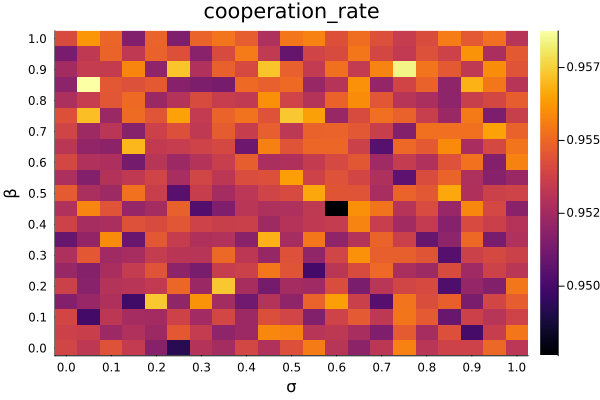

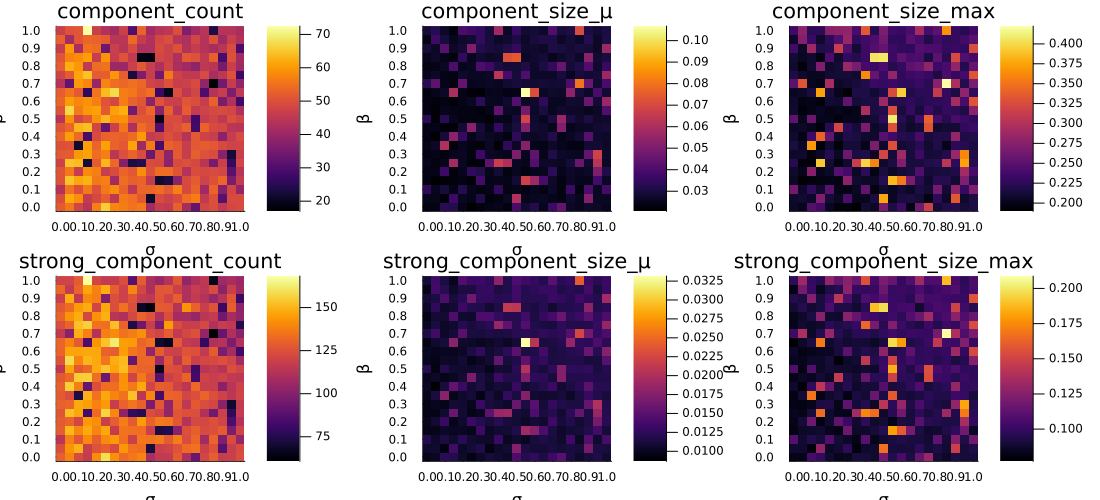

In [20]:
display(plot_heatmap(mean_df_ND, :cooperation_rate))

plot(
    plot_heatmap(mean_df_ND, :component_count),
    plot_heatmap(mean_df_ND, :component_size_μ),
    plot_heatmap(mean_df_ND, :component_size_max),
    plot_heatmap(mean_df_ND, :strong_component_count),
    plot_heatmap(mean_df_ND, :strong_component_size_μ),
    plot_heatmap(mean_df_ND, :strong_component_size_max),
    layout = (2, 3),
    size = (1100, 500),
)